# Dataset Processing

1. Split `successful` and `unsuccessful` paths
2. For each human path, find the corresponding `shortest path length` from the `source` article to the `target` article. We make the assumption that `Wikispeedia` games with the same `shortest path length` have the same `difficulty` 
3. Next, take the human navigation paths with the same `difficulty` and further fix the `human path length`
4. Generate a matched dataset where the `successful` and `unsucessful` paths both have the same `shortest path length` **and** `human path length`

Use this matched dataset to answer the following question:

***When given X number of choices in the same difficulty game, how did successful and unsuccessful players differ in their clicking behaviour?***

In [1]:
import pandas as pd
import os

parent_folder_path = '../Wikispeedia/wikispeedia_paths-and-graph/'

paths_finished_df=(pd.read_csv(os.path.join(parent_folder_path, 'paths_finished.tsv'), 
                               sep='\t', skiprows=15, header=None)
                   .rename(columns={0:"ip",
                                    1:"timestamp",
                                    2:"duration",
                                    3:"path",
                                    4:"rating"}))

paths_unfinished_df=(pd.read_csv(os.path.join(parent_folder_path, 'paths_unfinished.tsv'), 
                               sep='\t', skiprows=16, header=None)
                     .rename(columns={0:"ip",
                                      1:"timestamp",
                                      2:"duration",
                                      3:"path",
                                      4:"target",
                                      5:"type"}))

## Split `successful` and `unsuccessful` paths. For each path, find the shortest length path from the `source` to the `target`

In [2]:
# first read the shortest path matrix
shortest_path_matrix = []

with open('../Wikispeedia/wikispeedia_paths-and-graph/shortest-path-distance-matrix.txt', 'r') as f:
    # the first 17 lines (indexed from 0) is the file description 
    for line in f.readlines()[17:]:
        shortest_path_matrix.append(line)
        
# the matrix now stores all shortest paths from all source articles
len(shortest_path_matrix)

4604

In [3]:
# next, we need a list of all the article names. The order of the articles 
# is the same as the shortest_path_matrix as per the file descriptions

articles = pd.read_csv('../Wikispeedia/wikispeedia_paths-and-graph/articles.tsv', sep='\t', skiprows=11, header=None)[0]
article_names_cleaned = []

# NOTE TO GINEVRA:
# I need to change the function below to use urlparse

# some articles have encoded names. Decode these
for article in articles:
    # the "%" character indicates an encoded name
    if "%" not in article:
        # store the article name
        article_names_cleaned.append(article)
    else:
        with open(os.path.join('../Wikispeedia/plaintext_articles', f'{article}.txt'), 'r') as f:
            # extract the correct name. It is always on the 3rd line of the article
            correct_name = f.readlines()[2].replace('\n', '')
            # store the article name
            article_names_cleaned.append(correct_name)

article_names_cleaned[:3]

['Áedán mac Gabráin', 'Åland', 'Édouard Manet']

In [4]:
# for each human path, perform the following steps:
#      1. extract the source and target article
#      2. find the *index* in the article names list that corresponds to the source and target article
#      3. the corresponding *index* row in the shortest path matrix corresponds to the source article. 
#         from this list of numbers, use the target article *index* to find the *shortest path length*

def augment_with_shortest_path(df: pd.DataFrame, successful: bool) -> pd.DataFrame:
    """
    this function takes a Series and returns a DataFrame with the following columns:
       1. path
       2. source article
       3. target article
       4. shortest path length
       
    input:
       df: the Pandas DataFrame containing all the human navigation paths
       successful: a boolean indicating whether the paths were successful or not
    """
    # remove all paths with back-tracks
    df = df[~df['path'].str.contains('<')]
    
    def clean_query_article_name(name: str) -> str:
        """this helper function takes an encoded article name and returns the cleaned name"""
        if "%" in name:
            with open(os.path.join('../Wikispeedia/plaintext_articles', f'{name}.txt'), 'r') as f:
                # extract the correct name. It is always on the 3rd line of the article
                return f.readlines()[2].replace('\n', '')    
        else:
            return name
        
    paths, human_path_lengths, source_articles, target_articles, shortest_paths = [], [], [], [], []
    
    # all information required for successful paths is in the path itself
    if successful:
        for human_path in df['path']:
            paths.append(human_path)

            split_path = human_path.split(';')
            # subtract 1 because we do not count the source article
            human_path_lengths.append(len(split_path)-1)

            source = clean_query_article_name(split_path[0])
            target = clean_query_article_name(split_path[-1])
            source_articles.append(source)
            target_articles.append(target)
    
    # unsuccessful paths require extraction of the target article from a separate column
    else:
        for human_path, target in zip(df['path'], df['target']):
            paths.append(human_path)
            
            split_path = human_path.split(';')
            # subtract 1 because we do not count the source article
            human_path_lengths.append(len(split_path)-1)

            source = clean_query_article_name(split_path[0])
            source_articles.append(source)
            target_articles.append(target)
        
    for source, target in zip(source_articles, target_articles):
        source_index = article_names_cleaned.index(source)
        # there are target articles that were not provided in the plain text files
        try:
            target_index = article_names_cleaned.index(target)
        except Exception:
            shortest_paths.append("N/A")
            continue
            
        # query the shortest path matrix to get the correct vector (corresponding to the source article)
        shortest_path_vector = shortest_path_matrix[source_index]
        # now find the target article indexed integer in the vector
        shortest = shortest_path_vector[target_index]
        # it's not always possible to get to the target article. Impossible navigation is denoted by "_"
        if shortest == "_":
            shortest_paths.append("Impossible")
        else:
            shortest_paths.append(int(shortest))
        
        
    # create the augmented DataFrame
    out = pd.DataFrame({
                      'path': paths,
                      'source_article': source_articles,
                      'target_article': target_articles,
                      'human_path_length': human_path_lengths,
                      'shortest_path_length': shortest_paths
                      })
    
    return out

In [5]:
successful_df = augment_with_shortest_path(df=paths_finished_df, successful=True)
# to investigate human behaviour, we remove all "Impossible paths" and also shortest_path_length = 0
successful_df = successful_df[(successful_df['shortest_path_length'].apply(lambda x: x != 'Impossible' and x != 0))]
# next, we will keep only shortest_path_lengths >= 3
successful_df = successful_df[(successful_df['shortest_path_length'].apply(lambda x: x >= 3))]

successful_df.head(3)

,path,source_article,target_article,human_path_length,shortest_path_length
0,14th_century;15th_century;16th_century;Pacific...,14th_century,African_slave_trade,8,3
1,14th_century;Europe;Africa;Atlantic_slave_trad...,14th_century,African_slave_trade,4,3
2,14th_century;Niger;Nigeria;British_Empire;Slav...,14th_century,African_slave_trade,7,3


In [6]:
unsuccessful_df = augment_with_shortest_path(df=paths_unfinished_df, successful=False)

# some target articles for unsuccessful paths were not provided in the plain_text folder, denoted in
# the DataFrame as "N/A". Remove these
unsuccessful_df = unsuccessful_df[(unsuccessful_df['shortest_path_length'].apply(lambda x: x != 'N/A' and x != 'Impossible'))]
# some unsuccesful paths only contain 1 article because the user didn't click anything
# these are less meaningful paths to analyze as we are interested in users who tried but failed
# we will keep paths where the human clicked at least 3 articles
unsuccessful_df = unsuccessful_df[(unsuccessful_df['shortest_path_length'].apply(lambda x: x >= 3))]
unsuccessful_df = unsuccessful_df[(unsuccessful_df['human_path_length'].apply(lambda x: x >= 3))]
unsuccessful_df.head(3)


,path,source_article,target_article,human_path_length,shortest_path_length
5,Agriculture;History_of_the_world;China;Yangtze...,Agriculture,Grand_Canal_of_China,3,3
6,Mind;Christianity;Europe;Renaissance;Ancient_G...,Mind,Scouting,6,4
7,4-2-0;United_States;Agriculture;Sugar;Australia,4-2-0,Cane_Toad,4,5


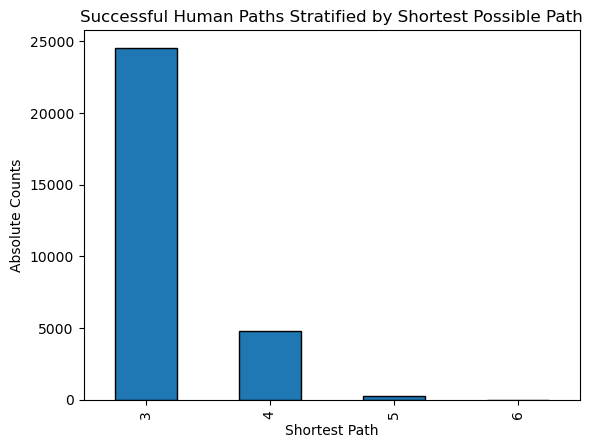

In [7]:
# take a look at the shortest_path distributions
import matplotlib.pyplot as plt

successful_counts = successful_df['shortest_path_length'].value_counts()
successful_counts.plot(kind='bar', edgecolor='k')
plt.ylabel('Absolute Counts'); plt.xlabel('Shortest Path');
plt.title("Successful Human Paths Stratified by Shortest Possible Path");

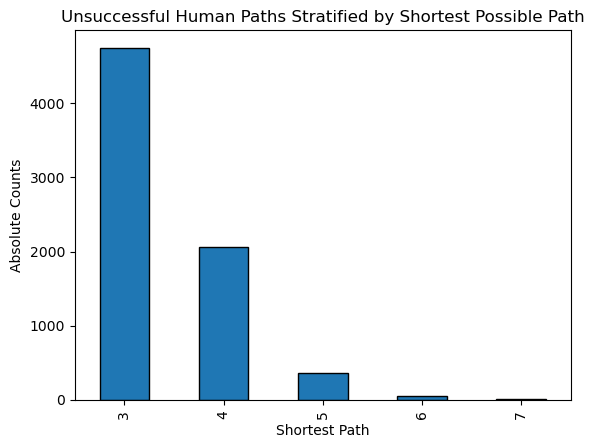

In [8]:
unsuccessful_counts = unsuccessful_df['shortest_path_length'].value_counts()
unsuccessful_counts.plot(kind='bar', edgecolor='k')
plt.ylabel('Absolute Counts'); plt.xlabel('Shortest Path');
plt.title("Unsuccessful Human Paths Stratified by Shortest Possible Path");

The majority of `shortest path lengths` is 3 for both successful and unsuccessful paths. For this specific length, let's visualize the distribution of the actual human paths.

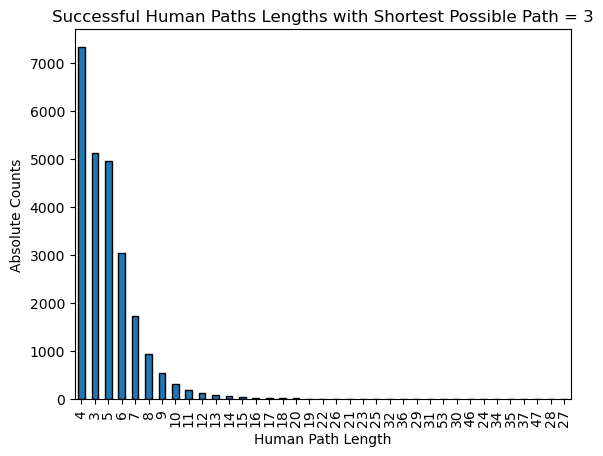

In [9]:
successful_human_path_lengths_3 = successful_df[successful_df['shortest_path_length'] == 3]
successful_human_path_lengths_3['human_path_length'].value_counts().plot(kind='bar', edgecolor='k')
plt.ylabel('Absolute Counts'); plt.xlabel('Human Path Length');
plt.title("Successful Human Paths Lengths with Shortest Possible Path = 3");

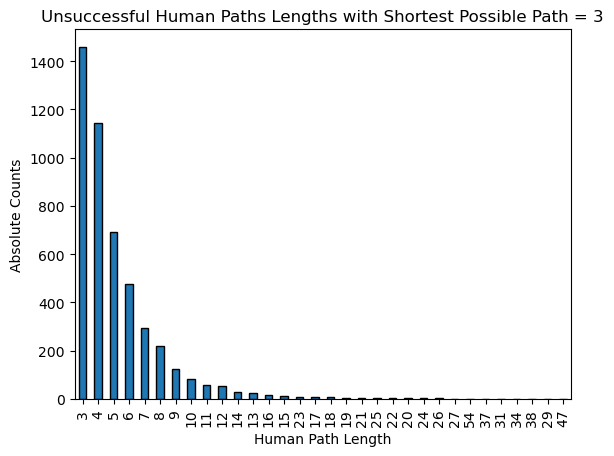

In [10]:
unsuccessful_human_path_lengths_3 = unsuccessful_df[unsuccessful_df['shortest_path_length'] == 3]
unsuccessful_human_path_lengths_3['human_path_length'].value_counts().plot(kind='bar', edgecolor='k')
plt.ylabel('Absolute Counts'); plt.xlabel('Human Path Length');
plt.title("Unsuccessful Human Paths Lengths with Shortest Possible Path = 3");

Given a `shortest path length` of 3, the majority of `human path lengths` are 3, 4, 5 for both successful and unsuccessful paths. Let's filter the corresponding DataFrames to only keep these path lengths. The matched analysis will be done with these lengths.

In [11]:
successful_df = successful_df[(successful_df['shortest_path_length'].apply(lambda x: x == 3))]
successful_df = successful_df[(successful_df['human_path_length'].apply(lambda x: 3 <= x <= 5))]
successful_df.head(3)

,path,source_article,target_article,human_path_length,shortest_path_length
1,14th_century;Europe;Africa;Atlantic_slave_trad...,14th_century,African_slave_trade,4,3
5,14th_century;Europe;North_America;United_State...,14th_century,John_F._Kennedy,5,3
6,14th_century;China;Gunpowder;Fire,14th_century,Fire,3,3


In [12]:
unsuccessful_df = unsuccessful_df[(unsuccessful_df['shortest_path_length'].apply(lambda x: x == 3))]
unsuccessful_df = unsuccessful_df[(unsuccessful_df['human_path_length'].apply(lambda x: 3 <= x <= 5))]
unsuccessful_df.head(3)

,path,source_article,target_article,human_path_length,shortest_path_length
5,Agriculture;History_of_the_world;China;Yangtze...,Agriculture,Grand_Canal_of_China,3,3
13,Ape;Asia;Computer;Automobile,Ape,Tin,3,3
14,Symmetry;Science;Age_of_Enlightenment;Dark_Age...,Symmetry,Scottish_Episcopal_Church,5,3


At this point, we have filtered the successful and unsuccessful DataFrames by the following conditions:

1. Shortest path length = 3 --> we hypothesize that all paths have the same "difficulty" by enforcing this 
2. The actual human path lengths are 3,4,5 --> the majority of human paths are within these lengths

The next step is to perform matching of datasets. To make this process possible, we first augment both successful and unsuccessful DataFrames with `is_successful` Boolean condition.

In [13]:
successful_df['is_successful'] = 1
unsuccessful_df['is_successful'] = 0

# merge the successful and unsuccessful DataFrames
final_df = pd.concat([successful_df, unsuccessful_df])
final_df.reset_index(drop=True, inplace=True)

final_df.head(3)

# next, we perform dataset matching for human path lengths of 3,4,5

,path,source_article,target_article,human_path_length,shortest_path_length,is_successful
0,14th_century;Europe;Africa;Atlantic_slave_trad...,14th_century,African_slave_trade,4,3,1
1,14th_century;Europe;North_America;United_State...,14th_century,John_F._Kennedy,5,3,1
2,14th_century;China;Gunpowder;Fire,14th_century,Fire,3,3,1


In [ ]:
import networkx as nx

# define the treatment and control

# NOTE TO GINEVRA:
# I was just testing the matching algorithm and the function so the stuff below is not correct
# I would split based on my semantic distance conditions and not successful or not

treatment_df = final_df[final_df['is_successful'] == 1]
control_df = final_df[final_df['is_successful'] == 0]

def perform_matching(length: int) -> pd.DataFrame:
    """this function performs matching of successful and unsuccessful navigation paths
       based on a given human path length. Returns the matched DataFrame"""
    
    G = nx.Graph()
    
    for control_id, control_row in control_df.iterrows():
        for treatment_id, treatment_row in treatment_df.iterrows():
            # Adds an edge only for the same human path length
            if (control_row['human_path_length'] == length and treatment_row['human_path_length'] == length):
                G.add_edge(control_id, treatment_id)

    matching = nx.max_weight_matching(G)
    matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
    balanced_df = final_df.iloc[matched]
    
    return balanced_df

In [ ]:
balanced_df = perform_matching(length=3)

In [ ]:
len(balanced_df)

## 2 . Document Similarity

### Similarity Between Wikipedia Articles: 'Bag-of-Words' Cosine Similarity Based on Word Frequencies

We are interested in measuring ***similarity*** between `Wikipedia` articles to investigate players' strategies in `Wikispeedia`. The proposed similarity is `Cosine Similarity` measured on word frequencies given a pair of articles. **Therefore, the assumption we make is that articles with similar occurrences of words are similar.** 

In order to mitigate similarity due to common English words such as "the", we apply a filter as follows:

1. Remove all `Stop` words as defined in `Scikit-learn`
* https://scikit-learn.org/stable/modules/feature_extraction.html#nqy18

2. Remove all white spaces and `\n` characters


3. Apply a scaled version of word frequency count as implemented in `TfidfTransformer` in `Scikit-learn`: 
* https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer

The cell blocks below show our data processing pipeline.

In [ ]:
import os

base_path = '../wikispeedia/plaintext_articles'
articles = os.listdir(base_path)
# sort the article names in alphabetical order. This is not strictly required
articles = sorted(articles)

def remove_duplicates_and_fix_names(articles: list):
    """this function parses all the articles provided in the plaintext folder and stores the
       names of all the articles after "cleaning" them (some articles containing accents have encoded names).
       The raw text from the files are also stored in a list after removing white spaces and empty lines."""
    
    def parse_text(article: str) -> str:
        """this helper function reads a raw text file and removes white spaces and empty lines."""
        with open(os.path.join(base_path, article)) as f:
            # remove white spaces
            raw_text = [line.rstrip() for line in f.readlines()]
            # remove empty lines
            raw_text = [line.strip() for line in raw_text if line != '']

            return str(raw_text)
    
    # some article names have errors - fix these
    article_names_cleaned, texts = [], []
    
    for article in articles:
        # the "%" character indicates an encoded name
        if "%" not in article:
            # store the article name
            article_names_cleaned.append(article)
            # store the raw text from the article
            texts.append(parse_text(article))
            
        else:
            with open(os.path.join(base_path, article), 'r') as f:
                # extract the correct name. It is always on the 3rd line of the article
                correct_name = f.readlines()[2].replace('\n', '')
                # store the article name
                article_names_cleaned.append(correct_name)
                # store the raw text from the article
                texts.append(parse_text(article))
                    
    
    # remove ".txt" from the article names
    article_names_cleaned = [article.replace('.txt', '') for article in article_names_cleaned]
    # remove list bracket from string casting of raw text
    texts = [text.replace('[', '') for text in texts]
    
    return article_names_cleaned, texts

article_names_cleaned, texts = remove_duplicates_and_fix_names(articles)

In [ ]:
# count word frequency using sklearn out-of-the-box functions
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
import numpy as np

# remove common stop words
tfid_vectorizer = TfidfVectorizer(stop_words='english')
# apply CountVectorizer and TfidfTransform sequentially
matrix = tfid_vectorizer.fit_transform(texts)
matrix = matrix.todense()

# by default, "TfidfVectorizer" uses l2 norm and thus, to obtain the Cosine Similarity,
# we simply perform a dot product of the matrix
cosine_sim = pd.DataFrame(np.dot(np.array(matrix), np.array(matrix).T), columns=article_names_cleaned)
# assign the index names also as the article names. This is used for easy querying pairs of articles
cosine_sim.index = article_names_cleaned        
cosine_sim

In [ ]:
# save the Cosine Similarity matrix so we do not have to re-compute it every time
np.save('cosine_similarity.npz', np.array(cosine_sim))

In [ ]:
import matplotlib.pyplot as plt

# let's take a look at the Cosine Similarity distribution of the most similar article to a given article
most_similar = []
for idx in range(len(cosine_sim)):
    # index [-2] because index [-1] is always = 1 since it is a self similarity
    most_similar.append(sorted(cosine_sim.iloc[idx])[-2])
    
# plot the similarities
pd.Series(most_similar).plot(kind='hist', edgecolor='k')
plt.title("Cosine Similarity Distribution of Most Similar Articles")
plt.xlabel("Cosine Similarity"); plt.ylabel("Absolute Counts")

# there are no glaring red flags, e.g., most Cosine Similarities close to 0 or 1

In [ ]:
# show a few concrete examples and see if our metric makes empirical sense
#cosine_sim['Ukraine'].sort_values()

# results look reasonable

In [ ]:
#cosine_sim['Zinc'].sort_values()
# results also look reasonable

In [ ]:
import seaborn as sns

# "Cygni" are star systems/extrasolar planets and thus are expected to be similar
# the time periods have some similarity
#sns.clustermap(cosine_sim.iloc[10:20, 10:20])

In [ ]:
# "Cancri" are exoplanets and thus are expected to be similar
# we again see similarity between time periods
#sns.clustermap(cosine_sim.iloc[50:60, 50:60])

In [ ]:
# after confirming that the Cosine Similarity method is informative, we next show the function
# we will use to extract similarity of articles in a navigation path

# first show a hard-coded navigation path for illustration
navigation_path = '14th_century;Time;Light;Rainbow'

In [ ]:
def get_path_cosine_similarity(path: str, matrix: pd.DataFrame, method: str='sequential') -> list:
    """this function takes a navigation path string and returns an array of the Cosine Similarity.
       Two methods are supported: 'sequential' (default) which measures the sequential similarity and 
       'target' which measures the similarity between the current article at the target article.
       
       Input:
       path: navigation path string
       matrix: pre-computed Cosine Similarity matrix
       method: measurement method (defaults to 'sequential')
       
       Return:
       list: list of similarity measures
    """
    
    # there is 1 article that is duplicated in the plaintext folder. Problematically, the duplicated
    # article has different names and navigation paths can point to these different names, yet the 
    # article is the same. This one exception is handled here. In the implementation, we do not have to 
    # worry about this particular article pointing back to itself as it is not possible
    
    # navigation paths are separated by ";"
    path = path.split(';')
    
    # if the path only contains the starting article, return None
    if len(path) == 1:
        return None
    
    path_sims = []
    
    def get_correct_name(query: str, base_path: str='../wikispeedia/plaintext_articles') -> str:
        """this nested function is called in case a path contains error characters.
           Returns the fixed path so it can be used to query the Cosine Similarity matrix."""
        if '_' in query and '%' not in query:
            return query
        elif query in ['Podcasting', 'Color', 'Fencing', 'Anemia', 'Quito']:
            return query
        else:
            with open(os.path.join(base_path, f'{query}.txt'), 'r') as f:
                out = f.readlines()[2].replace('\n', '')
                return out
    
    # compute the similarity between sequential nodes
    # output list length is N-1
    if method == 'sequential':
        for idx in range(0, len(path)-1, 1):
            try:
                path_sims.append(matrix.loc[path[idx]].loc[path[idx+1]])
            except Exception:
                # either path or both paths could be wrong - just "fix" both
                # treat the 1 exception due to duplicated file
                if get_correct_name(path[idx]) == 'Polish–Muscovite War (1605–1618)':
                    sim = float(cosine_sim.loc['Polish–Muscovite War (1605–1618)'].drop_duplicates()[get_correct_name(path[idx+1])])
                    path_sims.append(sim)
                    
                elif get_correct_name(path[idx+1]) == 'Polish–Muscovite War (1605–1618)':
                    sim = cosine_sim.loc[get_correct_name(path[idx])].drop_duplicates()['Polish–Muscovite War (1605–1618)']
                    path_sims.append(sim)
                    
                else:
                    path_sims.append(matrix.loc[get_correct_name(path[idx])].loc[get_correct_name(path[idx+1])])

                    
    # compute the similarity between the current node and the target node
    # output list length is N
    elif method == 'target':
        for idx in range(0, len(path), 1):
            try:
                path_sims.append(matrix.loc[path[idx]].loc[path[-1]])
            except Exception:
                # either path or both paths could be wrong - just "fix" both
                # treat the 1 exception due to duplicated file
                if get_correct_name(path[idx]) == 'Polish–Muscovite War (1605–1618)':
                    sim = cosine_sim.loc['Polish–Muscovite War (1605–1618)'].drop_duplicates()[get_correct_name(path[-1])]
                    path_sims.append(sim)
                    
                elif get_correct_name(path[-1]) == 'Polish–Muscovite War (1605–1618)':
                    sim = float(cosine_sim.loc[get_correct_name(path[idx])].drop_duplicates()['Polish–Muscovite War (1605–1618)'])
                    path_sims.append(sim)
                    
                else:
                    path_sims.append(matrix.loc[get_correct_name(path[idx])].loc[get_correct_name(path[-1])])
    
    else:
        raise ValueError('Unsupported similarity method: choose from "sequential" or "target".')
        
    return path_sims

In [ ]:
# print the navigation path for reference
print(navigation_path.split(';'))

# show the "sequential" method
sequential_sims = get_path_cosine_similarity(path=navigation_path,
                                             matrix=cosine_sim,
                                             method='sequential')
# intepreted as:
# sim(14th_century, Time) = 0.031
# sim(Time, Light) = 0.147
# sim(Light, Rainbow) = 0.158
# the similarity list is always N-1 in length, N = # nodes
sequential_sims

In [ ]:
# show the "target" method
target_sims = get_path_cosine_similarity(path=navigation_path,
                                         matrix=cosine_sim,
                                         method='target')
# intepreted as:
# sim(14th_century, Rainbow) = 0.008
# sim(Time, Rainbow) = 0.035
# sim(Light, Rainbow) = 0.158
# sim(Rainbow, Rainbow) = 1 (the path was successful so similarity is 1)
# the similarity list is now N in length, N = # nodes

# note: paths where the last index != 1 means the path was unsuccessful
target_sims

In [ ]:
# "sequential" similarity
finished_paths_seq_sims = [get_path_cosine_similarity(path, matrix=cosine_sim) for path in successful_df['path']]
unfinished_paths_seq_sims = [get_path_cosine_similarity(path, matrix=cosine_sim) for path in unsuccessful_df['path']]

# "target" similarity
finished_paths_target_sims = [get_path_cosine_similarity(path, matrix=cosine_sim, method='target') for path in successful_df['path']]
unfinished_paths_target_sims = [get_path_cosine_similarity(path, matrix=cosine_sim, method='target') for path in unsuccessful_df['path']]


In [ ]:
# next, write a function that returns whether the Cosine similarities in a navigation path are increasing/decreasing
def sims_to_bool_path(path: str):
    """this function takes a navgiation path as input and returns the path with same dimensions
       containing Booleans denoting whether the Cosine similarity is increasing"""
    # check if the path is None (occurs if the navigation path was only 1 article, i.e., the user didn't click anything)
    # for the purposes of this initial investigation, assume that a path length of 1 is uninformative
    # we acknowledge that it may carry meaning,
    # for example, we would need to check if it is possible for the user to get to the target article in 1 click
    if path is None or len(path) == 1:
        return None
    
    bool_path = []
    for idx in range(len(path)-1):
        if path[idx+1] > path[idx]:
            bool_path.append(True)
        else:
            bool_path.append(False)
    
    return bool_path
        

For an initial investigation into `Cosine Similarity based navigation`, check how many successful and unsuccesful paths contain only increasing cosine similarity.

In [ ]:
type(finished_paths_seq_sims[1])

In [ ]:
# show the pipeline for just "sequential" cosine similarity, i.e., sequential article nodes

# finished paths
finished_paths_seq_bool = [sims_to_bool_path(path) for path in finished_paths_seq_sims]
finished_paths_target_bool = [sims_to_bool_path(path) for path in finished_paths_target_sims]
# unfinished paths
unfinished_paths_seq_bool = [sims_to_bool_path(path) for path in unfinished_paths_seq_sims]
unfinished_paths_target_bool = [sims_to_bool_path(path) for path in unfinished_paths_target_sims]

# now keep only the ones that are strictly increasing in similarity

# this function filters paths that only contain strictly increasing Cosine similarities
def filter_strictly_increasing_sims(path_list: list):
    out = [path for path in path_list if path is not None]
    out = [path for path in out if False not in path]
    
    return out

# sequential
finished_paths_seq_increasing = filter_strictly_increasing_sims(finished_paths_seq_bool)
unfinished_paths_seq_increasing = filter_strictly_increasing_sims(unfinished_paths_seq_bool)

finished_paths_target_increasing = filter_strictly_increasing_sims(finished_paths_target_bool)
unfinished_paths_target_increasing = filter_strictly_increasing_sims(unfinished_paths_target_bool)

In [ ]:
print(f'There are a total of {len(finished_paths_seq_bool)} successful navigation paths, of which, {len(finished_paths_seq_increasing)} ({round(len(finished_paths_seq_increasing)/len(finished_paths_seq_bool)*100)}%) have strictly increasing Cosine similarities')

print(f'There are a total of {len(unfinished_paths_seq_bool)} unsuccessful navigation paths, of which, {len(unfinished_paths_eq_increasing)} ({round(len(unfinished_paths_seq_increasing)/len(unfinished_paths_seq_bool)*100)}%) have strictly increasing Cosine similarities')